# Import Python Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import category_encoders as ce
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import KMeansSMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import category_encoders as ce
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import KMeansSMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier


%matplotlib inline

import pandas as pd
from pandas import read_csv

import numpy as np
from numpy import isnan

import pickle5 as pickle
import os
import random

import matplotlib.pyplot as plt

from collections import Counter

import time

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
# from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

import seaborn as sns

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.pipeline import Pipeline

# from mlxtend.evaluate import bias_variance_decomp

from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load the Data

In [3]:
# Bring the 14619 rows and 306 features
features = '/Users/shobhasankar/W210/models/loc_15k_features.csv'
df_300 = pd.read_csv(features)
print(df_300.shape)
df_300.head()

(14619, 9)


,Unnamed: 0,cwa_determination,da_number,district,longitude,latitude,potential_wetland,county,state
0,0,0,LRB-1983-10120,Buffalo,-76.70773,42.85821,1,Cayuga,36.0
1,1,1,LRB-1985-69031,Buffalo,-75.85524,43.15230,0,Madison,36.0
2,2,1,LRB-1986-99614,Buffalo,-78.04046,42.68911,0,Wyoming,36.0
3,3,1,LRB-1990-97632,Buffalo,-78.77134,42.97994,1,Erie,36.0
4,4,1,LRB-1991-98611,Buffalo,-78.97142,43.21616,1,Niagara,36.0


In [4]:
# SET-1 Drop
df_300.drop(['Unnamed: 0','da_number'],axis=1,inplace=True)
print(df_300.shape)

(14619, 7)


In [5]:
# Function to factorize district and county
# No data leak here
def cat_to_numeric_func (data, columns):
    data[columns] = data[columns].apply(lambda x: pd.factorize(x)[0])
    return data

In [6]:
# Check for categorical columns
cols = df_300.columns
num_cols = df_300._get_numeric_data().columns
column_list=list(set(cols) - set(num_cols))
print("Convert categorical to numerical columns:",column_list)

cat_to_numeric_func(df_300, column_list)
print(df_300.shape)
df_300.tail()

Convert categorical to numerical columns: ['district', 'county']
(14619, 7)


,cwa_determination,district,longitude,latitude,potential_wetland,county,state
14614,0,36,-92.09857,34.32060,1,40,5.0
14615,0,36,-92.63156,35.90693,0,1141,5.0
14616,1,37,-95.55320,36.12439,0,1161,40.0
14617,1,37,-97.58169,35.65544,1,1146,40.0
14618,1,37,-98.98376,34.62336,1,997,40.0


In [7]:
print(df_300['county'].unique())
print(df_300['district'].unique())

[   0    1    2 ... 1176 1177 1178]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]


In [8]:
#Use a forward fill for state NaN
# Need to use the context information to properly choose the state.
# Double check this for data leak
df_300[['state']] = df_300[['state']].fillna(method='ffill')
df_300.head()

,cwa_determination,district,longitude,latitude,potential_wetland,county,state
0,0,0,-76.70773,42.85821,1,0,36.0
1,1,0,-75.85524,43.15230,0,1,36.0
2,1,0,-78.04046,42.68911,0,2,36.0
3,1,0,-78.77134,42.97994,1,3,36.0
4,1,0,-78.97142,43.21616,1,4,36.0


In [9]:
# Clean up NaN after train/test/val split
a = df_300.columns[df_300.isna().any()].tolist()
a

[]

In [10]:
# Separate X and y for Stratifiedshuffle
X = df_300.drop(['cwa_determination'], axis=1)
y = df_300['cwa_determination']

In [11]:
# Split data into train and test
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(X, y): # sss.split returns indices to split data
  X_train, X_test = X.loc[train_index], X.loc[test_index] 
  y_train, y_test = y.loc[train_index], y.loc[test_index] 

# Split Train data into 2 equal sets
sss_train = StratifiedShuffleSplit(n_splits=2, test_size=0.5, random_state=42)
for train_index1, train_index2 in sss_train.split(X_train, y_train): 
  X_train1, X_train2 = X.loc[train_index1], X.loc[train_index2] 
  y_train1, y_train2 = y.loc[train_index1], y.loc[train_index2] 

# Split test data into 2 equal sets
sss_test = StratifiedShuffleSplit(n_splits=2, test_size=0.5, random_state=42)
for test_index, validate_index in sss_test.split(X_test, y_test): 
  X_test, X_val = X.loc[test_index], X.loc[validate_index] 
  y_test, y_val = y.loc[test_index], y.loc[validate_index] 


# verify number of records 
print("\nTraining Set 1 Samples:", len(X_train1))
print("\nTraining Set 2 Samples:", len(X_train2))
print("\nTest Set Samples:",len(X_test))
print("\nValidate Set Samples:",len(X_val))


# verify class ratios
a11 = y_train1.sum()
a12 = y_train2.sum()
a2 = y_test.sum()
a3 = y_val.sum()

b11 = len(X_train1)
b12 = len(X_train2)
b2 = len(X_test)
b3 = len(X_val)
print("a11=",a11,"a12=",a12, " a2=", a2, ' a3=',a3)
print("b11=",b11,"b12=",b12, " b2=", b2, ' b3=',b3)



print("\nTraining Set 1 Class Ratio:", round(a11/(b11-a11),2))
print("\nTraining Set 2 Class Ratio:", round(a12/(b12-a12),2))
print("\nTest Set Class Ratio:", round(a2/(b2-a2),2))
print("\nValidation Set Class Ratio:", round(a3/(b3-a3),2))


Training Set 1 Samples: 5116

Training Set 2 Samples: 5117

Test Set Samples: 2193

Validate Set Samples: 2193
a11= 1613 a12= 1536  a2= 662  a3= 638
b11= 5116 b12= 5117  b2= 2193  b3= 2193

Training Set 1 Class Ratio: 0.46

Training Set 2 Class Ratio: 0.43

Test Set Class Ratio: 0.43

Validation Set Class Ratio: 0.41


In [12]:
print("Features:",X_train1.shape, X_train2.shape, X_val.shape, X_test.shape )
print("CWA Determination:",y_train1.shape, y_train2.shape, y_val.shape, y_test.shape)
X_train1.head()

Features: (5116, 6) (5117, 6) (2193, 6) (2193, 6)
CWA Determination: (5116,) (5117,) (2193,) (2193,)


,district,longitude,latitude,potential_wetland,county,state
10185,26,-82.38995,27.43982,0,850,12.0
614,1,-88.02795,41.57571,1,52,17.0
4267,10,-88.59868,43.13575,0,40,55.0
7619,22,-117.00921,48.01107,0,768,16.0
6961,19,-97.11204,45.31021,1,671,46.0


In [13]:
type(X_train1)

pandas.core.frame.DataFrame

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

imp = imp.fit(X_train)
X_train = imp.transform(X_train)

imp = imp.fit(X_train1)
X_train1 = imp.transform(X_train1)

imp = imp.fit(X_train2)
X_train2 = imp.transform(X_train2)

imp = imp.fit(X_val)
X_val = imp.transform(X_val)

imp = imp.fit(X_test)
X_test = imp.transform(X_test)

In [15]:
np.isnan(np.sum(X_train))

False

In [16]:
y_train1 = np.ravel(y_train1)
y_train2 = np.ravel(y_train2)

y_val = np.ravel(y_val)
y_test = np.ravel(y_test)

In [17]:
print(X_train.shape, X_val.shape, y_train1.shape, y_train2.shape, y_val.shape, y_test.shape)

(10233, 6) (2193, 6) (5116,) (5117,) (2193,) (2193,)


In [18]:
model1 = RandomForestClassifier(n_estimators=2000,random_state=42, class_weight={0:1,1:1}, min_samples_split=5,
                             min_samples_leaf=1,bootstrap='False', max_features='auto')

model2 = RandomForestClassifier(n_estimators=2000,random_state=42, class_weight={0:1,1:1}, min_samples_split=5,
                             min_samples_leaf=1,bootstrap='False', max_features='auto')

In [19]:
# Train 2 models for blending
clf_1=model1.fit(X_train1, y_train1)
clf_2=model2.fit(X_train2, y_train2)

Random Forest Model


Classification Report: Train-Set-1

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1555
           1       0.81      0.77      0.79       638

    accuracy                           0.88      2193
   macro avg       0.86      0.85      0.86      2193
weighted avg       0.88      0.88      0.88      2193

Train-Set-1 Balanced Accuracy Score: 85.04%
Train-Set-1 AUC: 0.850 


0.66 accuracy with a standard deviation of 0.03


<AxesSubplot:>

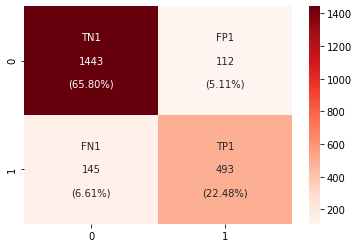

In [20]:
# Predict for test data
y_val_pred1 = clf_1.predict(X_val)
y_val_pred_proba1 = clf_1.predict_proba(X_val)

print("Random Forest Model\n")

# print classification report
result1 = classification_report(y_val, y_val_pred1)
print("\nClassification Report: Train-Set-1\n",)
print(metrics.classification_report(y_val, y_val_pred1, digits=2))

# print accuracy score
print("Train-Set-1 Balanced Accuracy Score: %.2f%%" % (metrics.balanced_accuracy_score(y_val, y_val_pred1)*100))

# calculate AUC
auc = roc_auc_score(y_val, y_val_pred1)
print('Train-Set-1 AUC: %.3f' % auc, "\n\n")

ppv = cross_val_score(clf_1, X_val, y_val, cv=10, scoring='precision')
print("%0.2f accuracy with a standard deviation of %0.2f" % (ppv.mean(), ppv.std()))

# Generate pretty Confusion Matrix
result = confusion_matrix(y_val, y_val_pred1)
group_names = ["TN1","FP1","FN1","TP1"]
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]

labels = [f"{v1}\n\n{v2}\n\n({v3})" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
              
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(result, annot=labels, fmt="", cmap='Reds')

Random Forest Model


Classification Report: Train-Set-2

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1555
           1       0.80      0.74      0.77       638

    accuracy                           0.87      2193
   macro avg       0.85      0.83      0.84      2193
weighted avg       0.87      0.87      0.87      2193

Train-Set-2 Balanced Accuracy Score: 83.03%
Train-Set-1 AUC: 0.830 


0.66 accuracy with a standard deviation of 0.03


<AxesSubplot:>

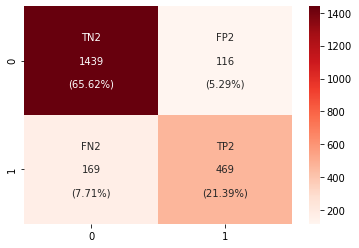

In [21]:
# Predict for test data
y_val_pred2 = clf_2.predict(X_val)
y_pred_proba2 = clf_2.predict_proba(X_val)

print("Random Forest Model\n")

# print classification report
result1 = classification_report(y_val, y_val_pred2)
print("\nClassification Report: Train-Set-2\n",)
print(metrics.classification_report(y_val, y_val_pred2, digits=2))

# print accuracy score
print("Train-Set-2 Balanced Accuracy Score: %.2f%%" % (metrics.balanced_accuracy_score(y_val, y_val_pred2)*100))

# calculate AUC
auc = roc_auc_score(y_val, y_val_pred2)
print('Train-Set-1 AUC: %.3f' % auc, "\n\n")

ppv = cross_val_score(clf_2, X_val, y_val, cv=10, scoring='precision')
print("%0.2f accuracy with a standard deviation of %0.2f" % (ppv.mean(), ppv.std()))

# Generate pretty Confusion Matrix
result = confusion_matrix(y_val, y_val_pred2)
group_names = ["TN2","FP2","FN2","TP2"]
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]

labels = [f"{v1}\n\n{v2}\n\n({v3})" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
              
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(result, annot=labels, fmt="", cmap='Reds')

In [22]:
# Get the predications and probabilities of train-1 on Validation Set
y_val_pred1 = clf_1.predict(X_val)
y_val_prob1 = clf_1.predict_proba(X_val).round(2)
val_pred_prob1 = y_val_prob1[np.arange(len(y_val)), y_val_pred1]
ppv = cross_val_score(clf_1, X_val, y_val, cv=10, scoring='precision')
print("%0.2f accuracy with a standard deviation of %0.2f" % (ppv.mean(), ppv.std()))

# Get the predications and probabilities of train-1 on Validation Set
y_val_pred2 = clf_2.predict(X_val)
y_val_prob2 = clf_2.predict_proba(X_val).round(2)
val_pred_prob2 = y_val_prob2[np.arange(len(y_val)), y_val_pred2]
ppv = cross_val_score(clf_1, X_val, y_val, cv=10, scoring='precision')
print("%0.2f accuracy with a standard deviation of %0.2f" % (ppv.mean(), ppv.std()))


print(len(val_pred_prob1), len(val_pred_prob2))

# Make a dataframe
# This is the train-final feature set to logistic regression
val_vote_feat=pd.DataFrame({'CWA':y_val, 'Set-1':y_val_pred1, 'Prob-1': val_pred_prob1, 
                            'Set-2':y_val_pred2, 'Prob-2': val_pred_prob2})

# print(val_vote_feat)

0.66 accuracy with a standard deviation of 0.03
0.66 accuracy with a standard deviation of 0.03
2193 2193


In [23]:
# Get the predications and probabilities of train-1 on Test Set
# This is the test-final feature set for the ensemble
y_test_pred1 = clf_1.predict(X_test)
y_test_prob1 = clf_1.predict_proba(X_test).round(2)
test_pred_prob1 = y_test_prob1[np.arange(len(y_test)), y_test_pred1]

y_test_pred2 = clf_2.predict(X_test)
y_test_prob2 = clf_2.predict_proba(X_test).round(2)
test_pred_prob2 = y_test_prob2[np.arange(len(y_test)), y_test_pred2]

# y_pred_1 = clf_1.predict(X_test)
# y_pred_2 = clf_2.predict(X_test)

print(len(test_pred_prob1), len(test_pred_prob2) )
test_vote_feat=pd.DataFrame({'CWA':y_test, 'Set-1':y_test_pred1, 'Prob-1': test_pred_prob1, 
                           'Set-2':y_test_pred2, 'Prob-2': test_pred_prob2
                           })

2193 2193


In [24]:
col_list = ['Set-1', 'Set-2']
val_vote_feat['sum'] = val_vote_feat[col_list].sum(axis=1)


all_FN=val_vote_feat[(val_vote_feat['sum'] == 0) & (val_vote_feat['CWA'] == 1)]
all_FP=val_vote_feat[(val_vote_feat['sum'] == 2) & (val_vote_feat['CWA'] == 0)]
print("All_FN count:", len(all_FN))
print("All_FP count:", len(all_FP))


All_FN count: 41
All_FP count: 19


In [25]:
from sklearn.linear_model import LogisticRegression

# col_list = ['CWA','Set-1','Prob-1','Set-2','Prob-2']
col_list = ['CWA','Set-1','Prob-1','Set-2','Prob-2']

X_train_vote = pd.DataFrame(val_vote_feat[col_list])
X_test_vote = pd.DataFrame(test_vote_feat[col_list])

# train_3, test_3 = train_test_split(df_pred_L2, test_size=0.2, random_state = 42)

X_train_vote = X_train_vote.drop(['CWA'], axis=1)
X_test_vote = X_test_vote.drop(['CWA'], axis=1)

# X_test_3 = test_3.drop(['CWA'], axis=1)

print(X_train_vote.shape, X_test_vote.shape)

clf_final = LogisticRegression()

clf_final = clf_final.fit(X_train_vote, y_val)
y_pred_final = clf_final.predict(X_test_vote)

(2193, 4) (2193, 4)


(2193,) (2193,)
Random Forest Ensemble Model


Classification Report: Train-Set Ensemble

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1531
           1       0.78      0.84      0.81       662

    accuracy                           0.88      2193
   macro avg       0.86      0.87      0.86      2193
weighted avg       0.88      0.88      0.88      2193

Train-Ensemble Balanced Accuracy Score: 86.92%
Train-Ensemble AUC: 0.869 


0.78 accuracy with a standard deviation of 0.04


<AxesSubplot:>

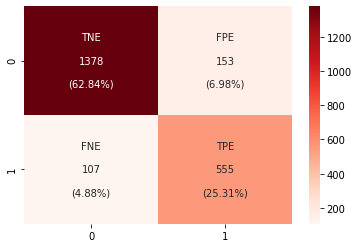

In [26]:
# Predict for test data
y_pred_final = clf_final.predict(X_test_vote)
y_pred_proba_final = clf_final.predict_proba(X_test_vote)

print(y_test.shape, y_pred_final.shape)
print("Random Forest Ensemble Model\n")

# print classification report
result1 = classification_report(y_test, y_pred_final)
print("\nClassification Report: Train-Set Ensemble\n",)
print(metrics.classification_report(y_test, y_pred_final, digits=2))

# print accuracy score
print("Train-Ensemble Balanced Accuracy Score: %.2f%%" % (metrics.balanced_accuracy_score(y_test, y_pred_final)*100))

# calculate AUC
auc = roc_auc_score(y_test, y_pred_final)
print('Train-Ensemble AUC: %.3f' % auc, "\n\n")

ppv = cross_val_score(clf_final, X_test_vote, y_test, cv=10, scoring='precision')
print("%0.2f accuracy with a standard deviation of %0.2f" % (ppv.mean(), ppv.std()))

# Generate pretty Confusion Matrix
result = confusion_matrix(y_test, y_pred_final)
group_names = ["TNE","FPE","FNE","TPE"]
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]

labels = [f"{v1}\n\n{v2}\n\n({v3})" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
              
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(result, annot=labels, fmt="", cmap='Reds')

In [27]:
# Check accuracy score 
# Random Forest Model (imputed NaN with most_frequent)
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
print('Model-1 accuracy score    : {0:0.4f}'. format(accuracy_score(y_val, y_val_pred1)))
print('Model-2 accuracy score    : {0:0.4f}'. format(accuracy_score(y_val, y_val_pred2)))
print('Blended accuracy score    : {0:0.4f}\n'. format(accuracy_score(y_test, y_pred_final)))


print('Blended Balanced Accuracy : {0:0.4f}'.format (balanced_accuracy_score(y_test, y_pred_final)))

Model-1 accuracy score    : 0.8828
Model-2 accuracy score    : 0.8700
Blended accuracy score    : 0.8814

Blended Balanced Accuracy : 0.8692


In [ ]:
## END OF SECTION ##